## Importing the libraries

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Importing the dataset

In [63]:
dataset = pd.read_excel("vm_dataset.xlsx")
# ilk 5, orta 5, son 5 satır
dataset.head()

,KOD,BARKOD,MAMUL,K.İÇİ,GR,LİSTE,FATURA ALTI %,DÖNEM SONU %,KDV,NET MALİYET,Ö.RAF,KATEGORİ,AY
0,67293883,8690637840746,1,8,400.0,21.85,12.0,5,0.01,18.449266,23.061583,FOOD,MART
1,67293891,8690637840821,1,8,400.0,21.85,12.0,5,0.01,18.449266,23.061583,FOOD,MART
2,67767533,8690637905896,1,12,600.0,27.00,13.0,5,0.01,22.538655,28.173319,FOOD,MART
3,67754288,8690637905193,1,12,600.0,27.00,13.0,5,0.01,22.538655,28.173319,FOOD,MART
4,68612788,8690637999277,1,8,335.0,39.75,10.0,5,0.01,34.326113,42.907641,FOOD,MART


In [64]:
selected_columns = ['KATEGORİ', 'AY', 'MAMUL', 'K.İÇİ', 'GR', 'LİSTE', 'NET MALİYET']
data_selected = dataset[selected_columns]
data_selected.head()

,KATEGORİ,AY,MAMUL,K.İÇİ,GR,LİSTE,NET MALİYET
0,FOOD,MART,1,8,400.0,21.85,18.449266
1,FOOD,MART,1,8,400.0,21.85,18.449266
2,FOOD,MART,1,12,600.0,27.00,22.538655
3,FOOD,MART,1,12,600.0,27.00,22.538655
4,FOOD,MART,1,8,335.0,39.75,34.326113


In [65]:
categorical_columns = ['KATEGORİ', 'AY', 'MAMUL']
numeric_columns = ['K.İÇİ', 'GR', 'LİSTE']

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)  # Ondalık sayıları iki basamaklı göster
pd.set_option('display.max_columns', None)  # Tüm sütunları göster
pd.set_option('display.width', 1000)  # Ekran genişliğini artır
data_selected.describe().round(2).T.rename(columns={'count': 'adet', 'mean': 'ortalama', 'std': 'standart sapma', 'min': 'min', '25%': '1.çeyrek', '50%': 'medyan', '75%': '3.çeyrek', 'max': 'maksimum'})

In [66]:
def detect_outliers(data, columns):
    # Aykırı değerleri saklamak için bir DataFrame oluştur
    outliers = pd.DataFrame()
    
    # Belirli sütunlar üzerinde döngü yap
    for column in columns:
        Q1, Q3 = np.percentile(data[column], 25), np.percentile(data[column], 75)
        # IQR hesapla
        iqr = Q3 - Q1
        # Aykırı değer eşik değerleri hesapla
        cut_off = iqr * 1.5
        lower, upper = Q1 - cut_off, Q3 + cut_off
        # Aykırı değerleri filtrele
        outliers = pd.concat([outliers, data[(data[column] < lower) | (data[column] > upper)]])
        
    # Toplanan aykırı değerleri içeren DataFrame'i geri döndür
    return outliers

# detect_outliers fonksiyonunu kullanarak aykırı değerleri tespit et
outliers = detect_outliers(data_selected, numeric_columns)

# Aykırı değerleri orijinal veri setinden çıkar
data_selected = data_selected.drop(outliers.index, axis=0)


In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.linear_model import LinearRegression

# Sayısal ve kategorik sütunları işlemek için bir sütun dönüştürücü oluşturun


# Sayısal ve kategorik sütunları işlemek için bir sütun dönüştürücü oluşturun
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns),
        
    ])


# Ön işlemciyi ve tahmin ediciyi bir boru hattına koyun ve modeli eğitin
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])




In [68]:
X = data_selected.drop('NET MALİYET', axis=1)
y = data_selected['NET MALİYET']


In [69]:
from sklearn.model_selection import train_test_split

# Verileri eğitim ve test kümelerine bölün
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
print(f'eğitim seti sayısı: {len(X_train)}')
print(f'test seti sayısı: {len(X_test)}')

eğitim seti sayısı: 2187
test seti sayısı: 547


In [71]:
# Modeli eğitin
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['K.İÇİ', 'GR', 'LİSTE']),
                                                 ('cat', OneHotEncoder(),
                                                  ['KATEGORİ', 'AY',
                                                   'MAMUL'])])),
                ('regressor', LinearRegression())])

#### Tahminlerde bulunmak için girdi 

In [72]:
new_data = pd.DataFrame({'KATEGORİ': ['PC'], 'AY': ['MAYIS'], 'MAMUL': [3],
                         'K.İÇİ': [104], 'GR': [2333], 'LİSTE': [400.0]})
prediction = model.predict(new_data)
print(f"Tahmin Edilen Net Maliyet: {prediction[0]}")

Tahmin Edilen Net Maliyet: 337.31705490134163


In [73]:
# Modelin test veri seti üzerinde tahmin yapması
y_pred = model.predict(X_test)

# Modelin yaptığı tahminleri içeren değişken
tahminler_sutunu = y_pred.reshape(len(y_pred), 1)

# Gerçek değerleri içeren değişken
gercek_sutunu = y_test.values.reshape(len(y_test), 1)

# Tahminler ve gerçek değerleri birleştirerek karşılaştırma veri setini oluştur
comparison_dataset = pd.DataFrame(
    np.concatenate((tahminler_sutunu, gercek_sutunu), 1),
    columns=['Tahmin', 'Gerçek'])
comparison_dataset.head(10)


,Tahmin,Gerçek
0,51.833789,47.934958
1,38.026856,38.115900
2,35.784874,24.404345
3,47.845657,43.247331
4,21.043368,23.612815
5,25.361155,29.573270
6,58.070613,54.618483
7,45.473444,53.932738
8,32.696605,30.991850
9,57.072535,55.344337


### MSE, MAE , RMSE ve R2 değerlerini hesaplama 

> MSE : Hata Kareler Ortalaması (0'a ne kadar yakınsa o kadar iyi) </br>
> RMSE : Hata Kareler Ortalamasının Karekökü (0'a ne kadar yakınsa o kadar iyi) </br>
> R2 : Determinasyon katsayısı (1'e ne kadar yakınsa o kadar iyi) </br>
> MAE : Ortalama Mutlak Hata (0'a ne kadar yakınsa o kadar iyi) </br>

In [74]:
# MSE, RMSE ve R2 değerlerini hesaplama 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

def model_performance(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE değeri: {mse}") # MSE : Hata Kareler Ortalaması (0'a ne kadar yakınsa o kadar iyi)
    print(f"RMSE değeri: {rmse}") # RMSE : Hata Kareler Ortalamasının Karekökü (0'a ne kadar yakınsa o kadar iyi)
    print(f"R2 değeri: {r2}") # R2 : Determinasyon katsayısı (1'e ne kadar yakınsa o kadar iyi)
    print(f"MAE değeri: {mae}") # MAE : Ortalama Mutlak Hata (0'a ne kadar yakınsa o kadar iyi)

model_performance(y_test, y_pred)


MSE değeri: 37.827996742262414
RMSE değeri: 6.150446873379398
R2 değeri: 0.9194110939153637
MAE değeri: 4.6034381025388615


In [75]:
# Modelin performansını test edin
print('Training R^2 score: %.3f' % model.score(X_train, y_train))
print('Test R^2 score: %.3f' % model.score(X_test, y_test))

Training R^2 score: 0.922
Test R^2 score: 0.919


In [76]:
# Tahmin ve gerçek değerli veri setini excel dosyası olarak kaydet
comparison_dataset.to_excel('comparison_dataset.xlsx', index=False)

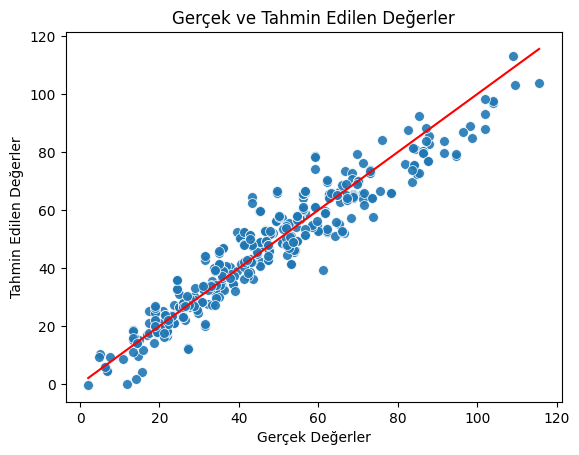

In [77]:
# visualize
sns.scatterplot(x=y_test, y=y_pred, alpha=0.9, s=50)
sns.lineplot(x=y_test, y=y_test, color='red')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek ve Tahmin Edilen Değerler')
plt.show()